In [31]:
# Load packages
import pandas as pd
import numpy as np
import time
import pytz
import matplotlib.pyplot as plt

import lxml.html as lx
import requests
import requests_cache

import newspaper
from newspaper import Article
from newspaper import news_pool

import re
import nltk
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import pickle

plt.rcParams["figure.figsize"] = [10, 8]

Useful links for newspaper3k:
https://opendatascience.com/using-the-newspaper-library-to-scrape-news-articles/
https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/

In [2]:
# Test the newspaper function.
link = "https://www.nytimes.com/2019/02/28/business/energy-environment/pge-camp-fire.html"
#link = 'https://krcrtv.com/news/butte-county/highway-70-to-be-closed-for-emergency-camp-fire-repairs'
#link = "http://krcrtv.com/news/butte-county/hundreds-of-trips-made-per-day-from-paradise-to-oroville-and-wheatland-with-debris"
#link = "https://krcrtv.com/news/camp-fire/camp-fire-debris-removal-could-be-halted-due-to-weather-cal-recycle-says"
article = Article(link)
article.download()
article.parse()
article.text

'Pacific Gas & Electric said Thursday that its equipment had probably caused the Camp Fire, the catastrophic November blaze that destroyed thousands of homes in Paradise, Calif., and killed at least 86 people.\n\nPG&E, which filed for bankruptcy protection in January, said it had recorded a $10.5 billion charge in anticipation of damage claims for that fire, the deadliest in state history. Largely as a result, the company reported a $6.9 billion loss for 2018.\n\nThough the cause of the fire is still under official investigation by California officials, PG&E said it “believes it is probable that its equipment will be determined to be an ignition point of the 2018 Camp Fire.” Attempts to determine the fire’s cause center on the 56-mile Caribou-Palermo electric transmission line.\n\nThe California Department of Forestry and Fire Protection has said the fire started at 6:33 a.m. on Nov. 8 near a tower on that line. PG&E said that its line de-energized at 6:15 a.m., adding that 15 minutes 

In [3]:
# Get google news links for each search term
search_term_links = [
    "https://news.google.com/search?q=camp%20fire&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20death%20toll&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20california&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20paradise&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20map&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20news&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20cleanup&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20debris%20removal&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20pg&e&hl=en-US&gl=US&ceid=US%3Aen",
    "https://news.google.com/search?for=camp%20fire%20investigation&hl=en-US&gl=US&ceid=US%3Aen"
]

In [4]:
# Get article links
def get_links(url):
    """Gets the article links for one Chronicle article list. The parameter "url" is the url to the 
    article list."""
    
    response = requests.get(url)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    html.make_links_absolute(url)
    
    # Get the links that contain the word "article".
    #links = html.xpath("//div/a/@href")
    links = html.xpath("//*[contains(@class, 'NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')]/a/@href")

    return links

In [5]:
# Get article links for each search term
l = [get_links(l) for l in search_term_links]

# Unlist the links and get the unique links.
links = [item for sublist in l for item in sublist]
links = np.unique(links)

len(links)

693

In [ ]:
# Extract text and publish data for the urls

def get_article_info(link):
    """Extract the title, text, publish date from a news article. The parameter link is the article link.
    Returns a dictionary of title, text, publish date, and url."""
    
    # Do not get the images.
    article = Article(link, fetch_images = False)
    
    # Not all articles can be downloaded/parsed.
    try:
        article.download()
        article.parse()
        
        title = article.title
        text = article.text # was in a try/except block
        date = article.publish_date
    except:
        # If article can't be parsed, set the variables to None.
        title = None
        text = None
        date = None
    
    url = link
    
    res = {"url": url, 
           "title": title, 
           "text": text,
           "date": date}
    
    return res

In [ ]:
# test it
link = links[1]
get_article_info(link)

In [ ]:
# Convert the article list to a dataframe.
articles = pd.DataFrame(article_list)

# Remove articles where we could not extract the the text.
articles = articles[~articles["text"].isna()]

# Convert the date column to datetime type
articles["date"] = pd.to_datetime(articles["date"], utc = True)

# Remove articles from paradise post (because this is from our local news source and we don't want overlap).
articles = articles[~articles["url"].str.contains("paradisepost")]

In [ ]:
# Extract article info. Returns a list of dictionaries.
# article_list = [get_article_info(x) for x in links]

# Save the dataframe
# articles.to_pickle("articles.txt")

# I saved the article dataframe with pickle so that I don't have to extract the article info again.
articles = pd.read_pickle("articles.txt")
articles.head()

In [6]:
# Only keep the title and text in this dataframe so we can merge all three news sources.

# Clean up the articles data frame.
# articles_gn = articles.loc[:,['text', 'title']]
# articles_gn["title"] = articles_gn["title"].str.replace("\n","")
# articles_gn["source"] = "Google News"

# Save the dataframe
#articles_gn.to_pickle("articles_gn.txt")
articles_gn = pd.read_pickle("articles_gn.txt")
articles_gn.head()

text  \
0  California wildfires are raging this summer, b...   
1  California wildfires are burning again, with t...   
2  Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...   
3  It’s one thing to read about the massive devas...   
4  PG&E is restructuring its board following the ...   

                                               title       source  
0  California Fires Map: Get the Latest Updates f...  Google News  
1  California Fires: Wildfires Map for Camp, Wool...  Google News  
2  35 Paradise Families Sue PG&E Over California'...  Google News  
3  Heartbreaking 360-Degree Film Shows Aftermath ...  Google News  
4  PG&E Board of Directors Is Restructuring After...  Google News

In [8]:
def tokenize_text(df):
    """Combine the strings in the "text" column of dataframe df into one long string. Then, tokenize the
    string and make all words lowercase."""
    
    # Combine the "text" column into a string.
    doc = ' '.join(df['text'].tolist())

    # Tokenize and make lowercase.
    words = nltk.word_tokenize(doc)
    words = [w.lower() for w in words]
    
    return words

In [9]:
# I took this function from Nick's lecture 2/14. It is for lemmitization.
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [10]:
def lemmatize_text(words):
    """Lemmatize words to get the base words. The input 'words' is a list of of words."""
    
    lemmatizer = nltk.WordNetLemmatizer()
    word_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in word_tags]
    
    return words

In [11]:
def remove_stopwords(words):
    """Remove stopwords from a string."""
    
    stopwords = nltk.corpus.stopwords.words("english")
    words = [w for w in words if w not in stopwords]
    
    return words

In [13]:
# Tokenize, lemmatize, and remove stopwords for the text of all articles.
words = tokenize_text(articles_gn)
words = lemmatize_text(words)
words = remove_stopwords(words)
words = [w for w in words if w.isalnum()]

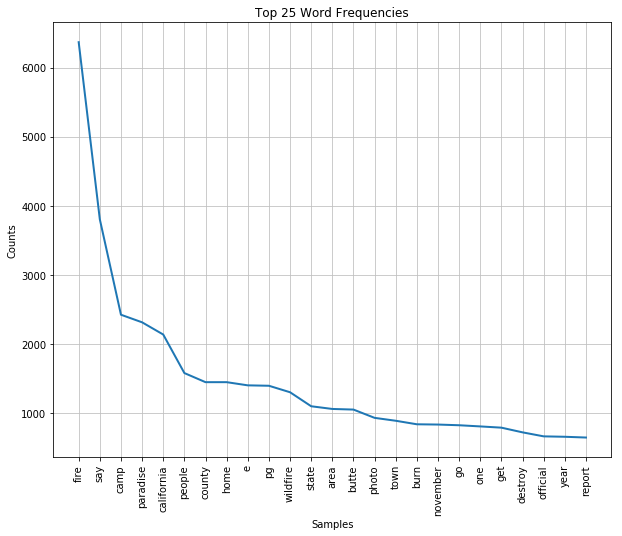

In [16]:
# Create a frequency plot.
fq = nltk.FreqDist(w for w in words if w.isalnum())
fq.plot(25, title = "Top 25 Word Frequencies")

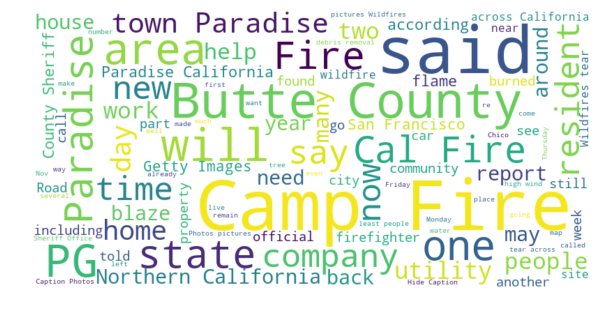

In [17]:
# Word cloud for all word articles we extracted from Google News.
doc = ' '.join(articles_gn['text'].tolist())
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
# This function is for cleaning the text for tfidf.
# I adapted this function from http://brandonrose.org/clustering so that it lemmitizes the words as well.

def tokenize_and_lem(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    lem = lemmatize_text(filtered_tokens)
    return lem


In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate the tfidf matrix for all google articles combined.
text_list = articles_gn['text'].tolist()
vec = TfidfVectorizer(max_df = 0.8, min_df=0.2,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

/Users/christinachang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [171]:
# Show tfidf dimensions.
tfidf

<644x117 sparse matrix of type '<class 'numpy.float64'>'
	with 22840 stored elements in Compressed Sparse Row format>

In [172]:
# Show some of the terms in the tfidf.
terms = vec.get_feature_names()
terms[:10]

["'s",
 'accord',
 'acre',
 'add',
 'agency',
 'area',
 'begin',
 'blaze',
 'burn',
 'butte']

In [23]:
# Tfidf for bigrams
text_list = articles_gn['text'].tolist()
vec_bigram = TfidfVectorizer(min_df=0.1,
                      tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True,
                      ngram_range=(2,2))
tfidf_bigram = vec_bigram.fit_transform(text_list)

In [24]:
# Show some of the terms from the bigram tfidf
terms_bigram = vec_bigram.get_feature_names()
terms_bigram[:10]

['butte county',
 'california department',
 'california history',
 'california s',
 'california wildfire',
 'county sheriff',
 'deadly wildfire',
 'death toll',
 'debris removal',
 'destroy home']

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

In [177]:
# Read the dataframe with the tweets, national news, and local news combined.
all_df = pd.read_pickle("all_df.txt")
all_df.head()

text  \
0  California wildfires are raging this summer, b...   
1  California wildfires are burning again, with t...   
2  Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...   
3  It’s one thing to read about the massive devas...   
4  PG&E is restructuring its board following the ...   

                                               title       source  
0  California Fires Map: Get the Latest Updates f...  Google News  
1  California Fires: Wildfires Map for Camp, Wool...  Google News  
2  35 Paradise Families Sue PG&E Over California'...  Google News  
3  Heartbreaking 360-Degree Film Shows Aftermath ...  Google News  
4  PG&E Board of Directors Is Restructuring After...  Google News

In [3]:
# Get unique text (to remove retweet) and get unique titles (for unique articles).
# all_u = all_df.drop_duplicates(subset=['text'])
# all_u = all_u.drop_duplicates(subset=['title'])

# all_u.to_pickle("all_nodup.txt")
all_nodup = pd.read_pickle("all_nodup.txt")

In [180]:
# Sample the dataframe. This code was adapted from 
# https://stackoverflow.com/questions/22472213/python-random-selection-per-group.

size = 30    # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
samp_all = all_nodup.groupby('source', as_index=False).apply(fn)
samp_all.head()

text  \
0 7    Camp Fire survivor Ralph Castro and his family...   
  70   William Godbout was a beloved figure in the Ba...   
  596  Roughly $33.5 million has been approved for su...   
  162  Close Get email notifications on Mike Hodgson ...   
  363  Backing away from President Donald Trump’s bli...   

                                                   title       source  
0 7    Camp Fire survivor moving to New York as victi...  Google News  
  70   Camp Fire profile: William Godbout, Bay Area c...  Google News  
  596  FEMA: $33 million approved for Camp Fire survi...  Google News  
  162  Santa Barbara County adopts mountain wildfire ...  Google News  
  363  Feds to Butte County: ‘You’re not going to be ...  Google News

In [181]:
# Generate the tfidf matrix.
text_list = samp_all['text'].tolist()
vec = TfidfVectorizer(tokenizer = tokenize_and_lem, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

/Users/christinachang/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [182]:
tfidf

<90x3949 sparse matrix of type '<class 'numpy.float64'>'
	with 10426 stored elements in Compressed Sparse Row format>

In [187]:
terms = vec.get_feature_names()
terms[:5]

["'d", "'god", "'ll", "'moving", "'probable"]

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

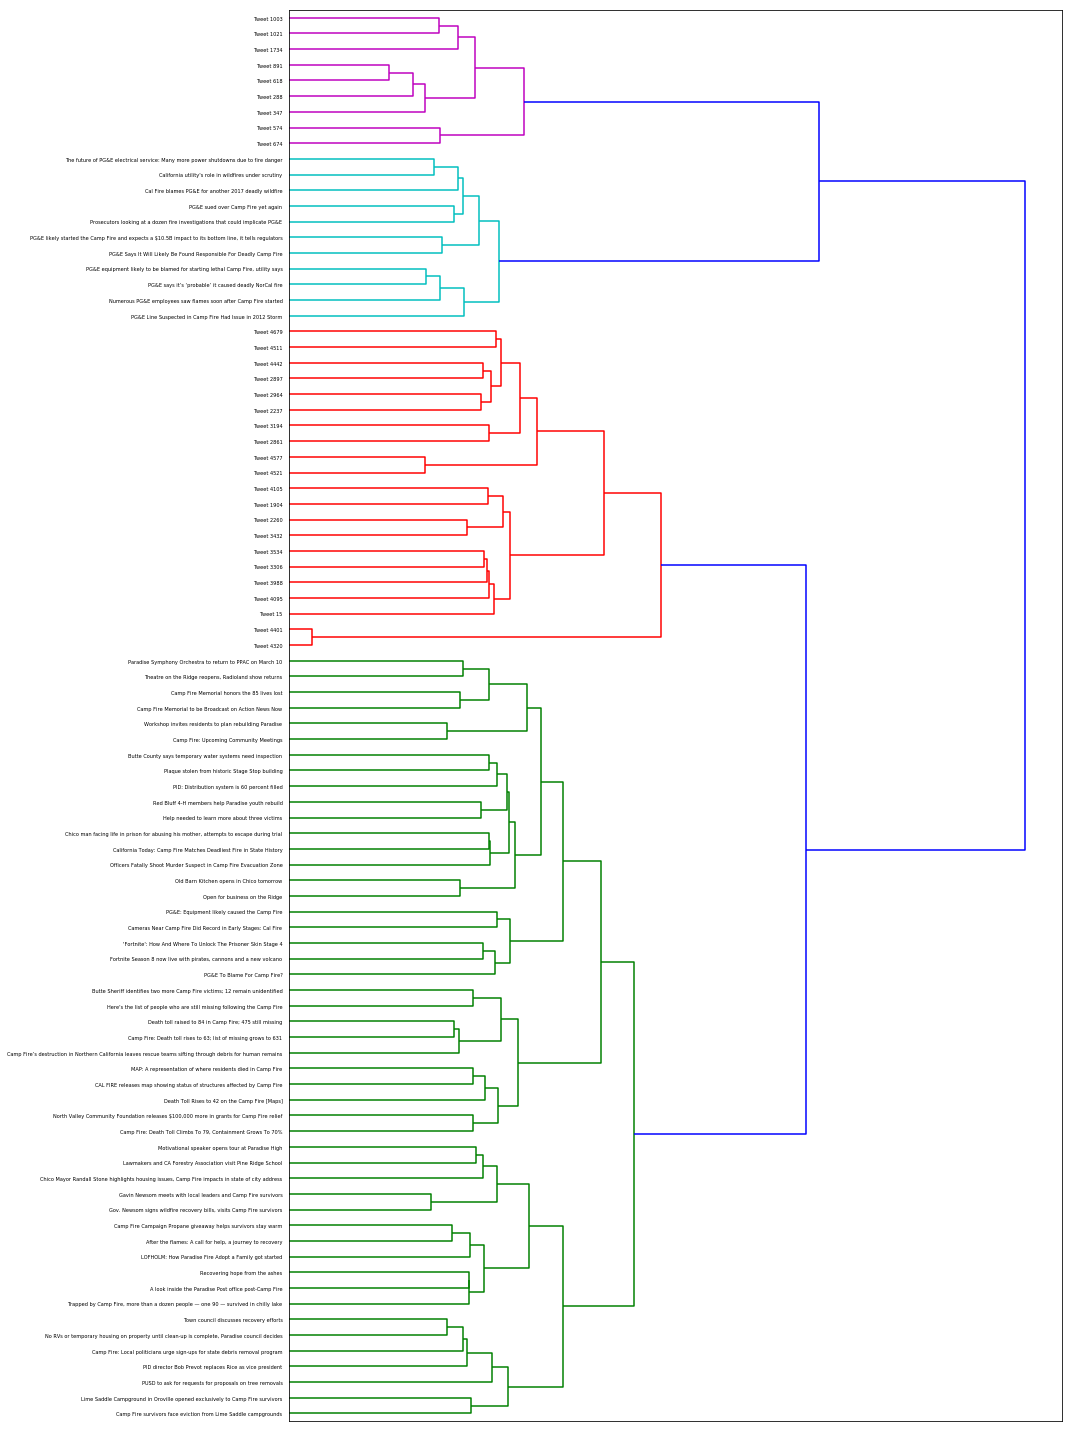

In [43]:
from scipy.cluster.hierarchy import ward, dendrogram


titles = samp_all["title"]

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

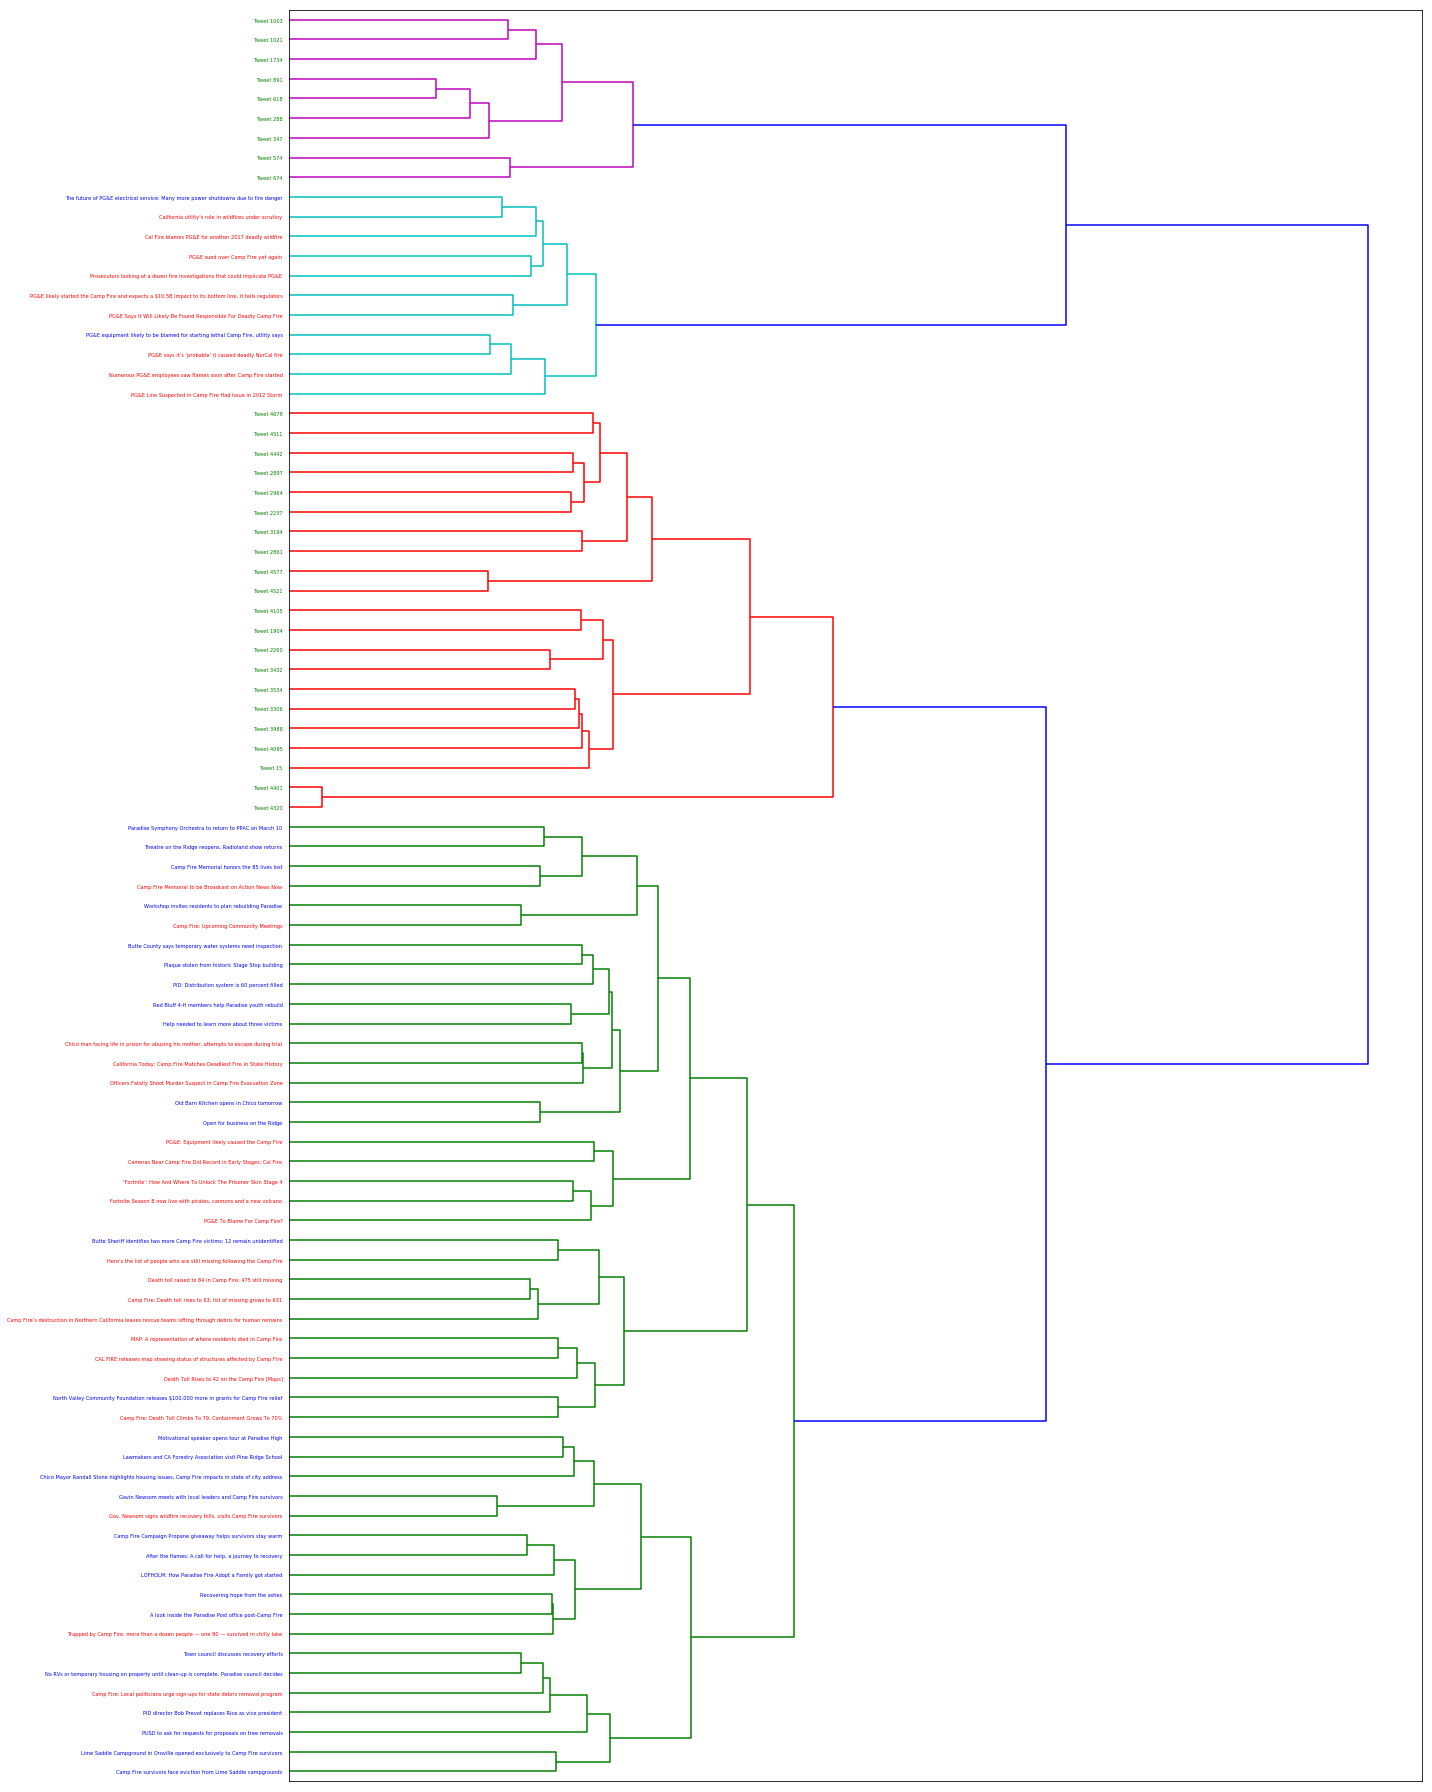

In [44]:
nodupe_sample = samp_all


linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20,25)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=nodupe_sample['title']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

#https://stackoverflow.com/questions/41597673/how-do-i-format-axis-ticks-to-be-a-certain-color-based-on-sign?noredirect=1&lq=1
label_colors = {'Google News': 'r', 'Twitter': 'g', 'Local': 'b'}

ax = plt.gca()
ylbls = ax.get_ymajorticklabels()
for lbl in ylbls:
    category = nodupe_sample[nodupe_sample['title'] == lbl.get_text()]
   # print(list(category['source'])[0])
    lbl.set_color(label_colors[list(category['source'])[0]])



plt.tight_layout() #show plot with tight layout

## k-means

In [4]:
# I adapted this function from http://brandonrose.org/clustering so that it lemmitizes the words as well.

def tokenize_and_lem(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    lem = lemmatize_text(filtered_tokens)
    return lem

def tokenize_only(text):
    """Tokenizes and lemmatizes a string. The input is a single string. The output is a list of words that
    has been tokenized and lemmatized."""
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    return filtered_tokens

In [19]:
# Jonathan's functions with regex
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|https|\\bamp\\b|rt", token) is None) and re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    lem = lemmatize_text(filtered_tokens)
    return lem


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|https|\\bamp\\b|rt", token) is None) and re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    return filtered_tokens

In [217]:
# Generate the tfidf matrix for the df with all the news sources.
text_list = all_nodup['text'].tolist()
# min_df = 0.1,
vec = TfidfVectorizer(tokenizer = tokenize_only, 
                      stop_words = "english", 
                      sublinear_tf = True)
tfidf = vec.fit_transform(text_list)

In [218]:
tfidf

<2555x16684 sparse matrix of type '<class 'numpy.float64'>'
	with 141189 stored elements in Compressed Sparse Row format>

In [320]:
terms = vec.get_feature_names()
terms[:10]

['^eas',
 'aanestad',
 'aaron',
 'aau',
 'ab',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment']

In [220]:
# Calculate the cosine distance.
dist = 1 - cosine_similarity(tfidf)

In [230]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf)

clusters = km.labels_.tolist()

In [231]:
# Create a new dataframe with the original data and the cluster assignments.
nodupe_k = all_nodup
nodupe_k["cluster"] = clusters
frame = nodupe_k
frame.head()

text  \
0  California wildfires are raging this summer, b...   
1  California wildfires are burning again, with t...   
2  Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...   
3  It’s one thing to read about the massive devas...   
4  PG&E is restructuring its board following the ...   

                                               title       source  cluster  
0  California Fires Map: Get the Latest Updates f...  Google News        2  
1  California Fires: Wildfires Map for Camp, Wool...  Google News        2  
2  35 Paradise Families Sue PG&E Over California'...  Google News        2  
3  Heartbreaking 360-Degree Film Shows Aftermath ...  Google News        2  
4  PG&E Board of Directors Is Restructuring After...  Google News        2

In [321]:
# Number of articles/tweets in a cluster
frame['cluster'].value_counts()

2    2041
0     399
1     115
Name: cluster, dtype: int64

In [323]:
# This code was adapted from http://brandonrose.org/clustering. It is for determining the top words 
# in each cluster. It gets the top 10 words that are closest to each centroid.
from __future__ import print_function

print("Top terms per cluster:")
print()

# Sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: says, e, pg, equipment, probably, caused, camp, california, probable, deadly,
Cluster 0 titles: California Fires Map: Get the Latest Updates from Google, No RVs or temporary housing on property until clean-up is complete, Paradise council decides, Tweet 0,

Cluster 1 words: dog, days, family, reunited, wildfire, reunites, lost, california, later, eating,
Cluster 1 titles: California Fires: Wildfires Map for Camp, Woolsey, Hill Fires, PUSD to ask for requests for proposals on tree removals, Tweet 1,

Cluster 2 words: camp, california, s, paradise, wildfire, people, said, pg, e, deadliest,
Cluster 2 titles: 35 Paradise Families Sue PG&E Over California's Camp Fire, Theatre on the Ridge reopens, Radioland show returns, Tweet 2,



## multidimentional scaling
https://en.wikipedia.org/wiki/Multidimensional_scaling

* Multidimensional scaling (MDS) is a means of visualizing the level of similarity of individual cases of a dataset. MDS is used to translate "information about the pairwise 'distances' among a set of n objects or individuals" into a configuration of n points mapped into an abstract Cartesian space.

* More technically, MDS refers to a set of related ordination techniques used in information visualization, in particular to display the information contained in a distance matrix. It is a form of non-linear dimensionality reduction. An MDS algorithm aims to place each object in N-dimensional space such that the between-object distances are preserved as well as possible.

* This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.

In [225]:
# This code was adapted from http://brandonrose.org/clustering. It converts a distance matrix to a 
# 2-dimentional coordinate representation of the data.

# Our distance matrix is composed of the cosine distances from the tfidf matrix.

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()

## visualize clusters

#### Test the number of clusters

##### 5 clusters
Cluster 0 words: http, california, camp, rt, s, https,

Cluster 1 words: say, people, county, paradise, s, butte,

Cluster 2 words: electric, pacific, gas, probable, equipment, amp,

Cluster 3 words: amp, pg, e, equipment, http, say,

Cluster 4 words: dog, reunite, family, day, wildfire, https,


##### 4 clusters
Cluster 0 words: california, camp, s, wildfire, paradise, deadliest,

Cluster 1 words: says, pg, e, equipment, probably, caused,

Cluster 2 words: dog, days, family, reunited, wildfire, reunites,

Cluster 3 words: said, people, county, paradise, butte, s,


##### 3 clusters
Cluster 0 words: camp, california, s, paradise, people, said,

Cluster 1 words: says, e, pg, equipment, probably, caused,

Cluster 2 words: dog, days, wildfire, family, california, home,

In [228]:
# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {0: 'California, camp', 
                 1: 'People, county, paradise, butte', 
                 2: 'Electric, pacific, equipment', 
                 3: 'Pg, e, equipment'}

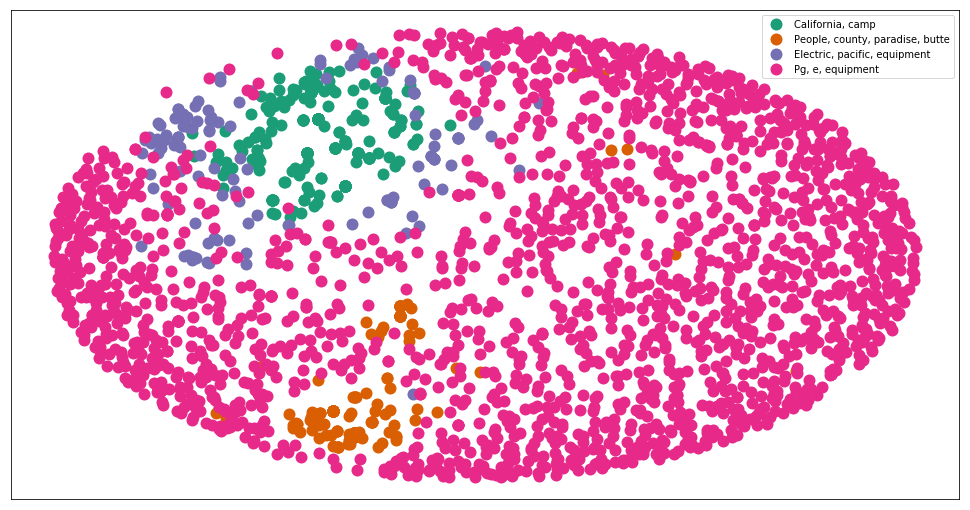

In [214]:
titles = frame["title"]

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

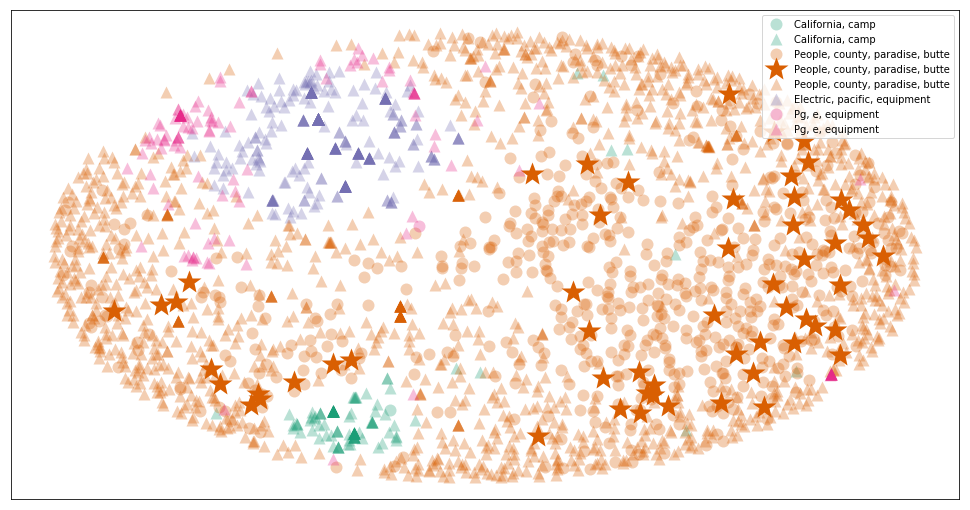

In [229]:
titles = frame["title"]
source = frame["source"]

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles, source = source)) 

#group by cluster
groups = df.groupby(['label', 'source'])


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


# Add markers
markers = ('+','o','>') 
mkr_dict = {'Google News': 'x', 'Twitter': '+', 'Local': 'o'}

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    keys = list(name)
    
    if keys[1] == "Google News":
        ax.plot(group.x, group.y, marker="o", linestyle='', ms=12, 
        label=cluster_names[keys[0]], color=cluster_colors[keys[0]], 
        mec='none', alpha = 0.3)
    elif keys[1] == "Twitter":
        ax.plot(group.x, group.y, marker="^", linestyle='', ms=12, 
        label=cluster_names[keys[0]], color=cluster_colors[keys[0]], 
        mec='none', alpha = 0.3)
    else:
        ax.plot(group.x, group.y, marker="*", linestyle='', ms=12, 
        label=cluster_names[keys[0]], color=cluster_colors[keys[0]], 
        mec='none', markersize=25)
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [61]:

plt.close()

In [279]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}
    

#set up cluster names using a dict
cluster_names = {0: 'Says, pg, e, equipment, probably, caused', 
                 1: 'Dog, days, family, reunited, wildfire, reunites', 
                 2: 'Camp, california, s, paradise, wildfire, people'}

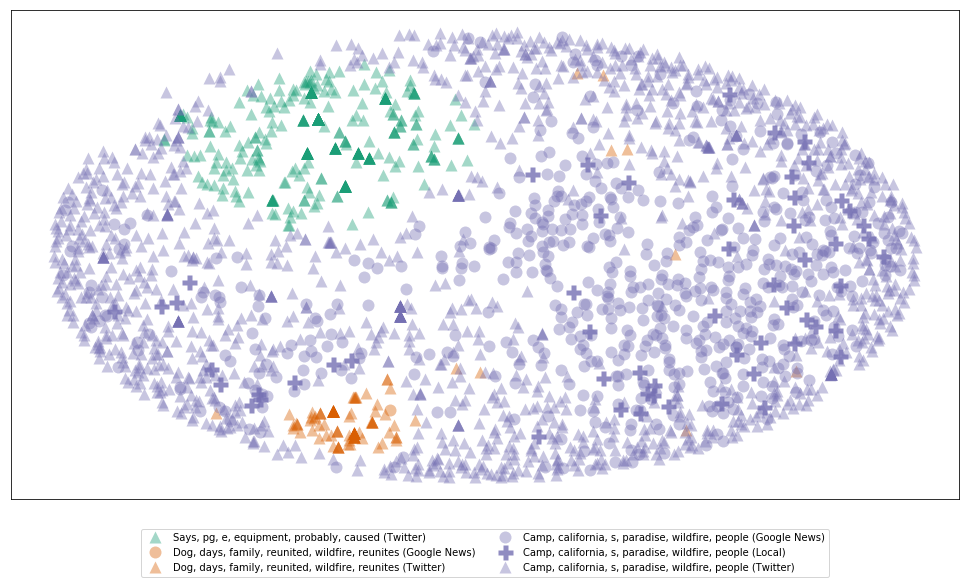

In [286]:
titles = frame["title"]
source = frame["source"]

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles, source = source)) 

#group by cluster
groups = df.groupby(['label', 'source'])


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling


# Add markers
markers = ('+','o','>') 
mkr_dict = {'Google News': 'x', 'Twitter': '+', 'Local': 'o'}

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    keys = list(name)
    
    if keys[1] == "Google News":
        ax.plot(group.x, group.y, marker="o", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[0]], 
        mec='none', alpha = 0.4)
    elif keys[1] == "Twitter":
        ax.plot(group.x, group.y, marker="^", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[0]], 
        mec='none', alpha = 0.4)
    else:
        ax.plot(group.x, group.y, marker="P", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[0]], 
        mec='none', alpha = 0.8, markersize=15)
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, ncol = 2, bbox_to_anchor=(0.5, -0.5))  #show legend with only 1 point

#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [318]:
#set up colors per clusters using a dict
#cluster_colors = {"Google News": '#1b9e77', "Twitter": '#d95f02', "Local": '#7570b3'}
cluster_colors = {"Google News": 'olivedrab', "Twitter":'cornflowerblue', "Local": 'darkorange'}
    

#set up cluster names using a dict
cluster_names = {0: 'Says, pg, e, equipment, probably, caused', 
                 1: 'Dog, days, family, reunited, wildfire, reunites', 
                 2: 'Camp, california, s, paradise, wildfire, people'}

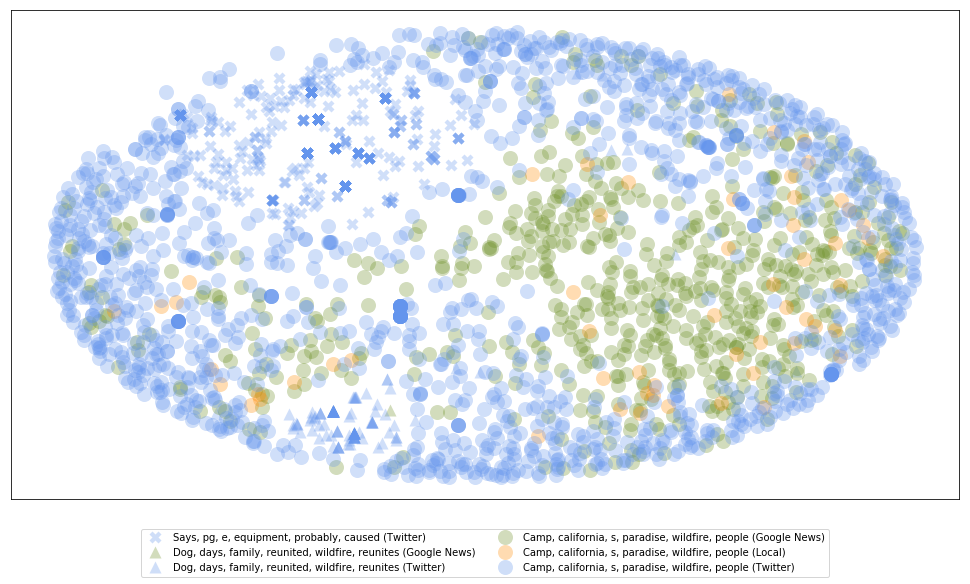

In [319]:
titles = frame["title"]
source = frame["source"]

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles, source = source)) 

#group by cluster
groups = df.groupby(['label', 'source'])


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    keys = list(name)
    
    if keys[0] == 0:
        ax.plot(group.x, group.y, marker="X", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[1]], 
        mec='none', alpha = 0.3)
    elif keys[0] == 1:
        ax.plot(group.x, group.y, marker="^", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[1]], 
        mec='none', alpha = 0.3)
    else:
        ax.plot(group.x, group.y, marker="o", linestyle='', ms=12, 
        label=cluster_names[keys[0]] + " " + "(" + keys[1] + ")", color=cluster_colors[keys[1]], 
        mec='none', alpha = 0.3, markersize=15)
    
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, ncol = 2, bbox_to_anchor=(0.5, -0.5))  #show legend with only 1 point

#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [62]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}
    

#set up cluster names using a dict
cluster_names = {0: 'camp, california, s, paradise, people, said', 
                 1: 'says, e, pg, equipment, probably, caused', 
                 2: 'dog, days, wildfire, family, california, home'}

/Users/christinachang/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


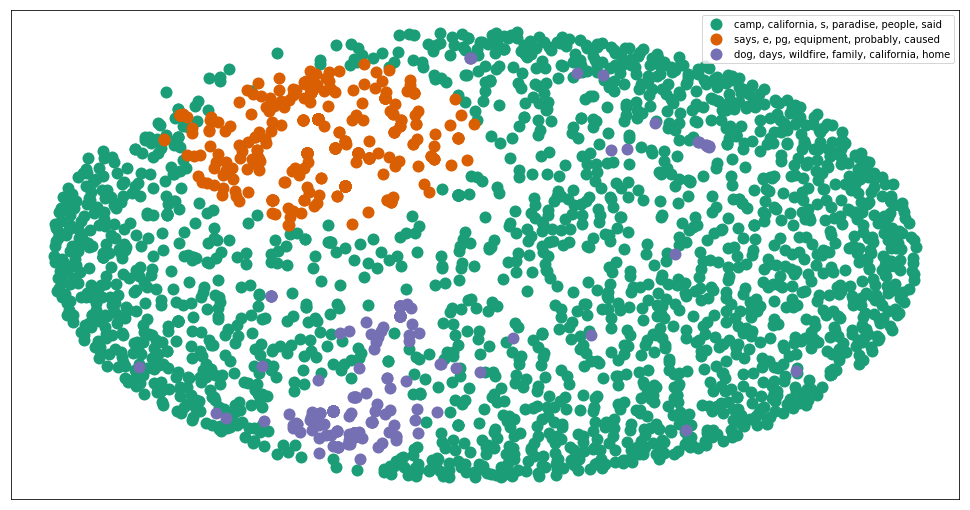

In [63]:
titles = frame["title"]

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)